# MERCS - Initial Notebook

Getting started with Avatar and Mercs

# Prelims

Preliminaries for rest of notebook.

In [1]:
# (Optional) Black codeformatter (`pip install nb_black`) for jupyterlab. In jupyter notebook, this changes slightly.
%load_ext lab_black

## Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
from mercs import Mercs

## Constants

In [4]:
ROOT_DIR = Path().resolve().parent.parent
DATA_DIR = ROOT_DIR / "data" / "raw"
DEMO_DIR = DATA_DIR / "demo"

In [5]:
NOMINAL_THRESHOLD = 10

# Implementation

Sandbox for writing code.

# Configuration

## Data

In [6]:
titanic_fp = DEMO_DIR / "titanic.csv"
titanic_fp.exists()

df = pd.read_csv(titanic_fp)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
usable_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c].dtype)]
df2 = df[usable_cols]
df2.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


lgtm

In [8]:
X = df2.values
X[:5]

array([[ 1.    ,  0.    ,  3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 2.    ,  1.    ,  1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    ,  1.    ,  3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       [ 4.    ,  1.    ,  1.    , 35.    ,  1.    ,  0.    , 53.1   ],
       [ 5.    ,  0.    ,  3.    , 35.    ,  0.    ,  0.    ,  8.05  ]])

In [9]:
nominal_attributes = [
    att_idx
    for att_idx, n_uvals in enumerate(df2.nunique())
    if n_uvals <= NOMINAL_THRESHOLD
]
nominal_attributes = set(nominal_attributes)

nominal_attributes

{1, 2, 4, 5}

In [10]:
# Sanity check
for c_idx, c in enumerate(df2.columns):
    if c_idx in nominal_attributes:
        print(c)

Survived
Pclass
SibSp
Parch


lgtm

## MERCS

Still stupid because mercs needs numpy, but you get the gist.

In [11]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="default",
    nb_targets=1,
    nb_iterations=1,
    n_jobs=1,
    # Inference
    inference_algorithm="own",
    prediction_algorithm="mi",
    max_steps=8,
    # Metadata
    nominal_attributes=nominal_attributes,
)

In [12]:
# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X, nominal_attributes=nominal_attributes)

In [13]:
clf.metadata

{'attributes': {0, 1, 2, 3, 4, 5, 6},
 'n_attributes': 7,
 'types': [dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64')],
 'nominal_attributes': {1, 2, 4, 5},
 'numeric_attributes': {0, 3, 6},
 'n_component_models': 7}

Alright so that looks sensible. Dtypes used to be relevant, now not anymore. Mercs runs on numpy so dtype has to be uniform.

In [14]:
# Inspection of models
clf.m_codes

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

So each model predicts one output, all the rest are inputs. 

A closer look, we can reveal other interesting stuff. For instance, model with index 3 predicts attribute index 1, and that is supposed to be nominal, let us see;

In [15]:
clf.m_list[3].desc_ids, clf.m_list[3].targ_ids, clf.m_list[3].out_kind

([0, 2, 3, 4, 5, 6], [1], 'nominal')

That looks pretty much as I expect it too.

Also probably of interest is how to get the underlying sklearn model (mercs has an internal extra layer of abstraction since it can also deal with xgboost etc)

In [16]:
clf.m_list[3].model

DecisionTreeClassifier(max_depth=8, random_state=270)

Here you go!

Now, to see which attribute matters for what, the feature importances matter. I will integrate SHAP soon for more power. For now, you access this datastruct like so;

In [17]:
fi = clf.m_fimps
fi

array([[1.43774372e-01, 2.13393335e-02, 5.43159156e-02, 3.21849228e-01,
        7.10551445e-02, 0.00000000e+00, 3.87666006e-01],
       [1.39795227e-01, 3.43145769e-02, 8.46433560e-02, 1.31555033e-01,
        0.00000000e+00, 7.83530050e-02, 5.31338802e-01],
       [2.17008567e-02, 1.56284762e-02, 0.00000000e+00, 5.29030213e-02,
        7.65630235e-02, 6.88926977e-02, 7.64311925e-01],
       [2.47448866e-01, 0.00000000e+00, 2.26707058e-01, 2.44169130e-01,
        8.25215007e-02, 1.74267276e-02, 1.81726718e-01],
       [3.17333277e-01, 3.53217487e-02, 4.06576765e-01, 5.55014624e-02,
        7.99444338e-02, 1.05322314e-01, 0.00000000e+00],
       [2.51624147e-01, 6.93343249e-02, 2.05690561e-01, 0.00000000e+00,
        7.83791360e-02, 2.12133812e-01, 1.82838019e-01],
       [0.00000000e+00, 1.22197983e-04, 0.00000000e+00, 5.39069957e-01,
        5.52670879e-02, 6.46792035e-03, 3.99072837e-01]])

In [18]:
np.sum(fi, axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [19]:
fi[3]  # Of model with index 3, i.e. the model that predict attribute with idx 1

array([0.24744887, 0.        , 0.22670706, 0.24416913, 0.0825215 ,
       0.01742673, 0.18172672])

So, to predict attribute 1, attributes 0, 2, and 3 seem to matter most.

To get an overview of which attributes globally matter most (without any regard for the performance of the component models obviously!), column summations of this fi datastructure are the way to go

In [20]:
np.sum(fi, axis=0)

array([1.12167675, 0.17606066, 0.97793366, 1.34504783, 0.44373033,
       0.48859648, 2.44695431])

So it looks like the last column is by far the most informative one, across ALL possible prediction tasks.

# Training for a Specific Target

Maybe we do not need a multi-directional model after all.

If you know this, how do you tell MERCS to ignore stuff?

In [21]:
X.shape

(891, 7)

In [22]:
custom_m_codes = np.zeros((1, 7))
custom_m_codes[0, 5] = 1
custom_m_codes

array([[0., 0., 0., 0., 0., 1., 0.]])

In [23]:
# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X, m_codes=custom_m_codes, nominal_attributes=nominal_attributes)

In [24]:
clf.m_codes

array([[0, 0, 0, 0, 0, 1, 0]])

In [25]:
clf.m_list

In [26]:
clf.m_list[0].desc_ids, clf.m_list[0].targ_ids, clf.m_list[0].out_kind

([0, 1, 2, 3, 4, 6], [5], 'nominal')

Alright so this one model that MERCS contained adheres to the m_codes that you gave AND the types were respected. 

# Obtaining a custom model

## Data

In [27]:
titanic_fp = DEMO_DIR / "titanic.csv"
titanic_fp.exists()

df = pd.read_csv(titanic_fp)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
usable_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c].dtype)]
df2 = df[usable_cols].copy()
df2.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [29]:
df2["Survived"] = df.Survived
df2 = df2[
    [c for c in df2.columns if c not in {"Survived", "PassengerId"}] + ["Survived"]
]
df2.head()

,Pclass,Age,SibSp,Parch,Fare,Survived
0,3,22.0,1,0,7.2500,0
1,1,38.0,1,0,71.2833,1
2,3,26.0,0,0,7.9250,1
3,1,35.0,1,0,53.1000,1
4,3,35.0,0,0,8.0500,0


In [30]:
df2.dropna(inplace=True)

In [31]:
X = df2.values
X[:5, :]

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ,  0.    ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833,  1.    ],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ,  1.    ],
       [ 1.    , 35.    ,  1.    ,  0.    , 53.1   ,  1.    ],
       [ 3.    , 35.    ,  0.    ,  0.    ,  8.05  ,  0.    ]])

## Mercs

In [32]:
nominal_attributes = {X.shape[1] - 1}
nominal_attributes

{5}

In [33]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="random",
    nb_targets=1,
    nb_iterations=10,
    fraction_missing=0.4,
    n_jobs=1,
    # Inference
    inference_algorithm="own",
    prediction_algorithm="rw",
    max_steps=8,
    nb_walks=5,
    # Metadata
    nominal_attributes=nominal_attributes,
)

# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X, nominal_attributes=nominal_attributes)

In [34]:
len(clf.m_codes)

60

In [35]:
clf.metadata

{'attributes': {0, 1, 2, 3, 4, 5},
 'n_attributes': 6,
 'types': [dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64'),
  dtype('float64')],
 'nominal_attributes': {5},
 'numeric_attributes': {0, 1, 2, 3, 4},
 'n_component_models': 60}

## Predict

In [36]:
X.shape

(714, 6)

In [37]:
q_code = np.array([-1, 0, 0, 0, 0, 1])
clf.predict(X, q_code=q_code)[:10]

array([0., 1., 0., 1., 0., 0., 0., 1., 1., 1.])

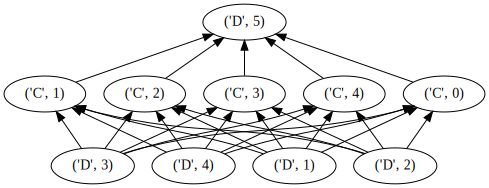

In [38]:
clf.show_q_diagram()

In [39]:
clf.q_model.classes_

[array([0., 1.])]

In [40]:
clf.q_model.desc_ids

[1, 2, 3, 4]

In [41]:
clf.q_model.targ_ids

[5]

In [42]:
y_pred = clf.q_model.predict(X[:, clf.q_model.desc_ids])

## SHAP Manual

In [43]:
import shap

X_desc = X[:, clf.q_model.desc_ids]
X_train = X_desc[:200, :]
X_test = X_desc[200:300, :]
bg_data = shap.sample(X_train, 100)


function_to_explain = lambda x: clf.q_model.predict_proba(x)[0]

explainer = shap.KernelExplainer(function_to_explain, bg_data, silent=True)

In [44]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [53]:
shap_values = explainer.shap_values(X_test, l1_reg="num_features(10)", silent=True)

np.mean(np.abs(shap_values[0]), axis=0), np.mean(np.abs(shap_values[1]), axis=0) / 1.64

(array([0.33060994, 0.14190972, 0.22949596, 0.36453787]),
 array([0.20159143, 0.08653032, 0.13993656, 0.22227919]))

In [46]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [47]:
np.sum(np.mean(np.abs(shap_values[0]), axis=0))

1.0665534918480615

## SHAP Avatar Function

In [48]:
clf.avatar_q_model(X_train, X_test, n_samples=200)

array([0.30474599, 0.12939281, 0.22773032, 0.33813088])

In [49]:
clf.avatar_q_model(X_train, X_test, n_samples=1)

array([0.29568166, 0.15563953, 0.13324768, 0.41543113])

In [50]:
clf.q_model.targ_ids
clf.q_model.nominal_targ_ids

{5}

In [51]:
clf.q_model.classes_

[array([0., 1.])]

In [52]:
type(clf)

mercs.core.Mercs.Mercs

# Test